In [1]:
from huggingface_hub import hf_hub_download
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from hyperopt import hp, tpe, fmin, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier

from preprocessing.utils import *

In [2]:
!set HF_HUB_DISABLE_SYMLINKS_WARNING=true

In [6]:
dataset = 'reg_cat/house_sales.csv'
dataset2 = 'reg_cat/Bike_Sharing_Demand.csv'
REPO_ID = "inria-soda/tabular-benchmark"

In [7]:
df = pd.read_csv(
    hf_hub_download(repo_id=REPO_ID, filename=dataset2, repo_type="dataset")
)
df

,season,year,month,hour,holiday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,1,0,1,0,0,0,0,9.84,14.395,0.81,0.0000,16
1,1,0,1,1,0,0,0,9.02,13.635,0.80,0.0000,40
2,1,0,1,2,0,0,0,9.02,13.635,0.80,0.0000,32
3,1,0,1,3,0,0,0,9.84,14.395,0.75,0.0000,13
4,1,0,1,4,0,0,0,9.84,14.395,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,2,10.66,12.880,0.60,11.0014,119
17375,1,1,12,20,0,1,2,10.66,12.880,0.60,11.0014,89
17376,1,1,12,21,0,1,0,10.66,12.880,0.60,11.0014,90
17377,1,1,12,22,0,1,0,10.66,13.635,0.56,8.9981,61


In [8]:
np.random.seed(42)
reg_cat_xgboost_scores = []

df = pd.read_csv(
    hf_hub_download(repo_id=REPO_ID, filename=dataset2, repo_type="dataset")
)
X, y = df.iloc[:, :-1], df.iloc[:, -1]
X, y = preprocess_data(X, y, isCategorical=False)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y, isCategorical=False)

# XGBoost
print('Running XGBoosting')
hyperparameter_space = {
    'max_depth': hp.uniformint('max_depth', 1, 11),
    'n_estimators': hp.quniform('n_estimators', 100, 6000, 200),
    'min_child_weight': hp.qloguniform('min_child_weight', np.log(1), np.log(1e2), 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(0.7)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(7)),
    'lambda': hp.loguniform('lambda', np.log(1), np.log(4)),
    'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1e2))
}

def objective_function(hyperparameters):
    global iteration_n
    if iteration_n == 0:
        model = XGBRegressor()
    else :
        hyperparameters['max_depth'] = int(hyperparameters['max_depth'])
        hyperparameters['n_estimators'] = int(hyperparameters['n_estimators'])
        hyperparameters['min_child_weight'] = int(hyperparameters['min_child_weight'])
        model = XGBRegressor(**hyperparameters)
    iteration_n += 1
    # score = -np.mean(cross_val_score(model, train_data.iloc[:, :-1], train_data.iloc[:, -1], cv=5, scoring='accuracy'))
    model.fit(X_train, y_train)
    y_predict = model.predict(X_val)
    score = -r2_score(y_val, y_predict)

    return score

trials = Trials()
iteration_n = 0
best_hyperparameters = fmin(objective_function, hyperparameter_space, algo=tpe.suggest, max_evals=20, trials=trials)
scores_round = -1 * np.array(trials.losses())

with open(f'best_reg_cat_xgboost_params.pkl', 'wb') as f:
    pickle.dump(best_hyperparameters, f)
reg_cat_xgboost_scores = scores_round.tolist()

Removed 0 rows with missing values on 17379 rows
Removed 0 columns with missing values on 11 columns
Removed 0 rows with missing values on 17379 rows
Removed 5 columns with pseudo-categorical values on 11 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|██████████| 20/20 [00:30<00:00,  1.54s/trial, best loss: -0.8097029656890776]


Text(0, 0.5, 'R-squared')

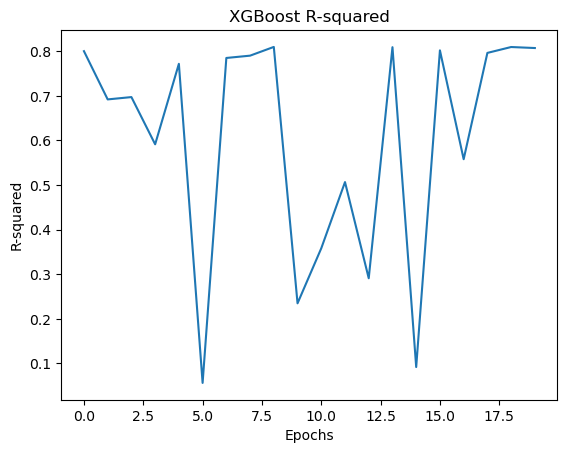

In [9]:
plt.plot(range(20), reg_cat_xgboost_scores)
plt.title('XGBoost R-squared')
plt.xlabel('Epochs')
plt.ylabel('R-squared')

In [10]:
best_hyperparameters

{'alpha': 0.5984373023640891,
 'colsample_bylevel': 0.8797420004341878,
 'colsample_bytree': 0.6369474723245352,
 'gamma': 1.910896143164079e-05,
 'lambda': 3.2004589241222563,
 'learning_rate': 0.002617770871996124,
 'max_depth': 7.0,
 'min_child_weight': 14.0,
 'n_estimators': 5200.0,
 'subsample': 0.8240634816581566}

In [11]:
trials.best_trial

{'state': 2,
 'tid': 8,
 'spec': None,
 'result': {'loss': -0.8097029656890776, 'status': 'ok'},
 'misc': {'tid': 8,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'alpha': [8],
   'colsample_bylevel': [8],
   'colsample_bytree': [8],
   'gamma': [8],
   'lambda': [8],
   'learning_rate': [8],
   'max_depth': [8],
   'min_child_weight': [8],
   'n_estimators': [8],
   'subsample': [8]},
  'vals': {'alpha': [0.5984373023640891],
   'colsample_bylevel': [0.8797420004341878],
   'colsample_bytree': [0.6369474723245352],
   'gamma': [1.910896143164079e-05],
   'lambda': [3.2004589241222563],
   'learning_rate': [0.002617770871996124],
   'max_depth': [7.0],
   'min_child_weight': [14.0],
   'n_estimators': [5200.0],
   'subsample': [0.8240634816581566]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 5, 20, 22, 21, 41, 137000),
 'refresh_time': datetime.datetime(2024, 5, 20, 22, 21, 44, 617000)}